# IMAGE WARPING and MOSAICING

In [1]:
import cv2

import numpy as np
import skimage as sk
import skimage.io as skio
from matplotlib import pyplot as plt

from skimage.draw import polygon
from Utils.ImagePointSet import ImagePointSet
from scipy.interpolate import griddata
from Utils.raw_image_operations import save_image

(893, 1311, 3)


Text(0.5, 1.0, 'Target image')

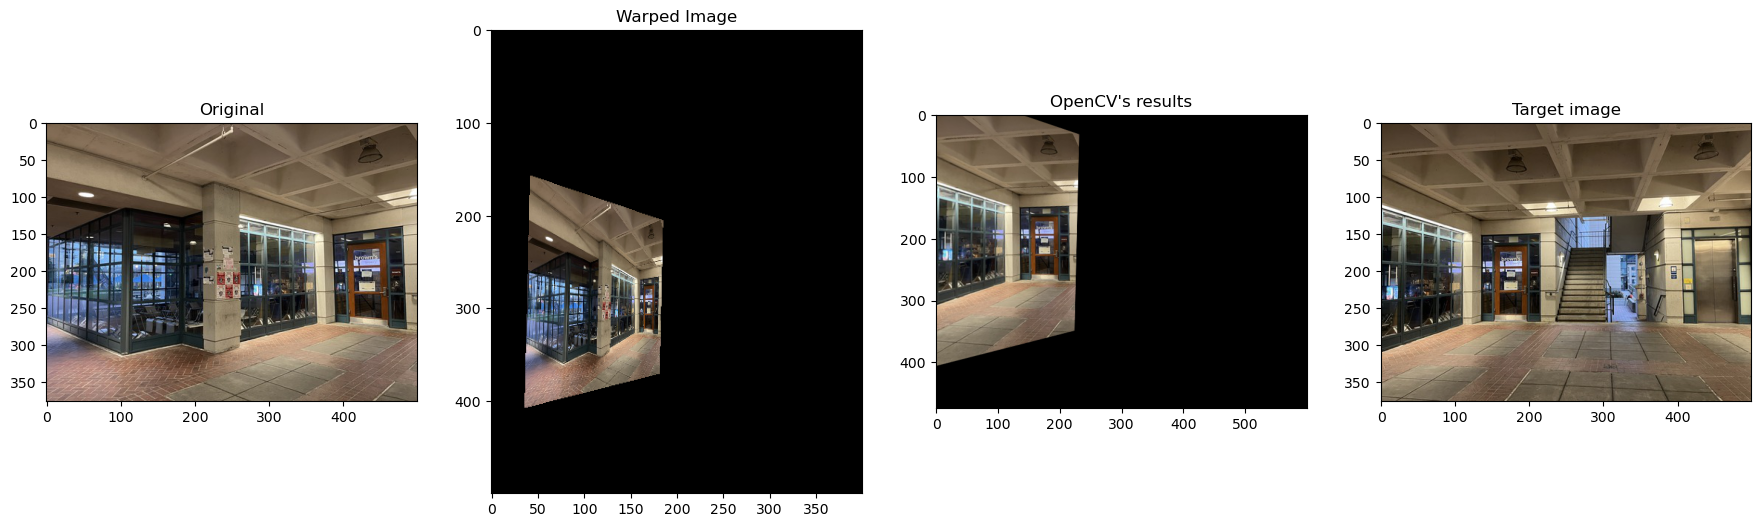

In [14]:
def compute_homography_matrix(src_points, dest_points):
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("At least 4 points are required.")
    if src_points.shape != dest_points.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    x, y = src_points[:, 0], src_points[:, 1]
    x_prime, y_prime = dest_points[:, 0], dest_points[:, 1]
    
    zeros = np.zeros(x.shape)
    ones = np.ones(x.shape)
    
    A1 = np.column_stack((-x, -y, -ones, zeros, zeros, zeros, x*x_prime, y*x_prime, x_prime))
    A2 = np.column_stack((zeros, zeros, zeros, -x, -y, -ones, x*y_prime, y*y_prime, y_prime))
    
    A = np.row_stack((A1, A2))

    _, _, vh = np.linalg.svd(A)
    homography_matrix = vh[-1].reshape(3, 3)
    
    return homography_matrix

# Used to verify method
def wrap_image_with_cv2(image, projection_matrix):
    h, w, _ = image.shape
    
    wrapped_image = cv2.warpPerspective(image, projection_matrix, (w + 100, h + 100))
    
    return wrapped_image

def apply_homography(x, y, homography_matrix):
    homogenous_coords = np.vstack((x, y, np.ones(x.size)))
    
    warped_homogenous_coords = np.dot(homography_matrix, homogenous_coords)
    warped_coords = (warped_homogenous_coords / warped_homogenous_coords[2])
    return warped_coords[0], warped_coords[1]

def get_warp_corners(image, homography_matrix):
    h, w, _ = image.shape
    image_corners = np.array([
        [0 ,0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ])
    return np.array(apply_homography(image_corners[:, 0], image_corners[:, 1], np.linalg.inv(homography_matrix)))

def get_all_points(image, is_switch_shapes=False):
    h, w, _ = image.shape
    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    x, y = np.meshgrid(x, y)
    return x.flatten().astype(int), y.flatten().astype(int)

def get_all_points_using_polygon(image, is_switch_shapes=False):
    h, w, _ = image.shape
    rr, cc = polygon([0, 0, h-1, h-1], [0, w-1, w-1, 0], shape=image.shape)
    return cc, rr

def get_warp_canvas_basics(image, homography_matrix):
    warped_corner_x, warped_corner_y = get_warp_corners(image, homography_matrix)
    warped_x_min, warped_y_min = np.min(warped_corner_x), np.min(warped_corner_y)
    
    warped_w = np.max(warped_corner_x) - warped_x_min if warped_x_min < 0 else np.max(warped_corner_x)
    warped_h = np.max(warped_corner_y) - warped_y_min if warped_y_min < 0 else np.max(warped_corner_y)
    
    warped_canvas = np.zeros((int(warped_h) + 1, int(warped_w) + 1, 3))
    
    return warped_canvas, warped_x_min, warped_y_min

def inverse_warp_image(image, homography_matrix, shift_x=0, shift_y=0):
    warped_canvas, warped_x_min, warped_y_min = get_warp_canvas_basics(image, homography_matrix)
    h, w, _ = warped_canvas.shape
    warped_x, warped_y = get_all_points(warped_canvas)
    
    canvas_x = warped_x.astype(int)
    canvas_y = warped_y.astype(int)
    
    warped_x = warped_x + warped_x_min if warped_x_min < 0 else warped_x
    warped_y = warped_y + warped_y_min if warped_y_min < 0 else warped_y
    warped_x, warped_y = apply_homography(warped_x, warped_y, np.linalg.inv(homography_matrix))
    
    warped_x += shift_x
    warped_y += shift_y
        
    warped_canvas[canvas_y, canvas_x, :] = griddata(
        get_all_points(image),
        image.reshape(-1, 3),
        (warped_x, warped_y),
        method='linear',
        fill_value=0
    )
    
    return warped_canvas.reshape(h, w, 3)

def forward_warp_image(image, projection_matrix):
    h, w, _ = image.shape
    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    x, y = np.meshgrid(x, y)
    homogenous_coords = np.vstack((x.flatten(), y.flatten(), np.ones(x.size)))
    
    warped_homogenous_coords = np.dot(np.linalg.inv(projection_matrix), homogenous_coords)
    warped_coords = warped_homogenous_coords / warped_homogenous_coords[2]
    
    warped_x = warped_coords[0]
    warped_y = warped_coords[1]
    
    warped_image = griddata(
        (homogenous_coords[0], homogenous_coords[1]),
        image.reshape(-1, 3),
        (warped_x, warped_y),
        method='linear',
        fill_value=0
    )
    
    return warped_image.reshape(h, w, 3)

test = ImagePointSet("hallway/hallway3_hallway4.json")
test_matrix = compute_homography_matrix(test.points[0], test.points[1])
warped_test_image = inverse_warp_image(test.images[0], test_matrix, shift_x=-700)
print(warped_test_image.shape)

_, axes = plt.subplots(1, 4, figsize=(22, 13))
axes[0].imshow(test.images[0])
axes[0].set_title("Original")
axes[1].imshow(warped_test_image[200:700, 300:700])
axes[1].set_title("Warped Image")
axes[2].imshow(wrap_image_with_cv2(test.images[0], test_matrix))
axes[2].set_title("OpenCV's results")
axes[3].imshow(test.images[1])
axes[3].set_title("Target image")


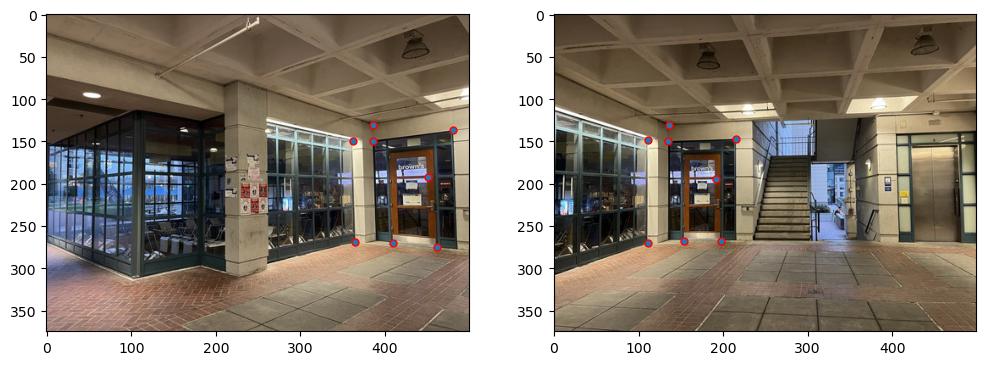

In [18]:
hallway0_hallway1 = ImagePointSet("hallway/hallway3_hallway4.json")
# hallway0_hallway1.display(True)

hallway0_hallway1.align_all_points()
hallway0_hallway1.display(True)

# hallway0_hallway1_projection_matrix = compute_homography_matrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
# warped_hallway0_hallway1_image = inverse_warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)


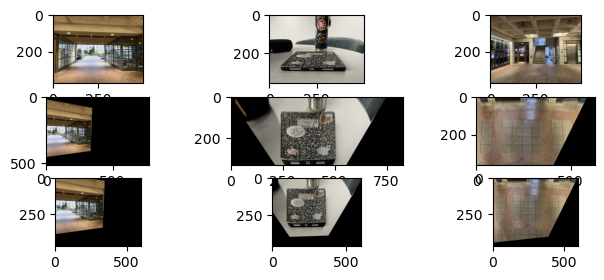

In [3]:
hallway0_hallway1 = ImagePointSet("hallway/hallway1_hallway2.json")
hallway0_hallway1_projection_matrix = compute_homography_matrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
warped_hallway0_hallway1_image = inverse_warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)

ipad_image_set = ImagePointSet("ipad_ipad.json")
ipad_image_set_matrix = compute_homography_matrix(ipad_image_set.points[0], ipad_image_set.points[1])
rectified_ipad_image = inverse_warp_image(ipad_image_set.images[0], ipad_image_set_matrix)
save_image(rectified_ipad_image, "rectified_ipad_image")

hallway1_rectify_image_set = ImagePointSet("hallway/hallway4_rectify.json")
hallway1_rectify_set_matrix = compute_homography_matrix(hallway1_rectify_image_set.points[0], hallway1_rectify_image_set.points[1])
rectified_hallway1_rectify_image = inverse_warp_image(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix)
save_image(rectified_hallway1_rectify_image, "rectified_hallway4_rectify_image")


_, axes = plt.subplots(3, 3, figsize=(8, 3))
axes[0, 0].imshow(hallway0_hallway1.images[0])
axes[0, 1].imshow(ipad_image_set.images[0])
axes[0, 2].imshow(hallway1_rectify_image_set.images[0])
axes[1, 0].imshow(warped_hallway0_hallway1_image)
axes[1, 1].imshow(rectified_ipad_image)
axes[1, 2].imshow(rectified_hallway1_rectify_image)
axes[2, 0].imshow(wrap_image_with_cv2(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix))
axes[2, 1].imshow(wrap_image_with_cv2(ipad_image_set.images[0], ipad_image_set_matrix))
axes[2, 2].imshow(wrap_image_with_cv2(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix))

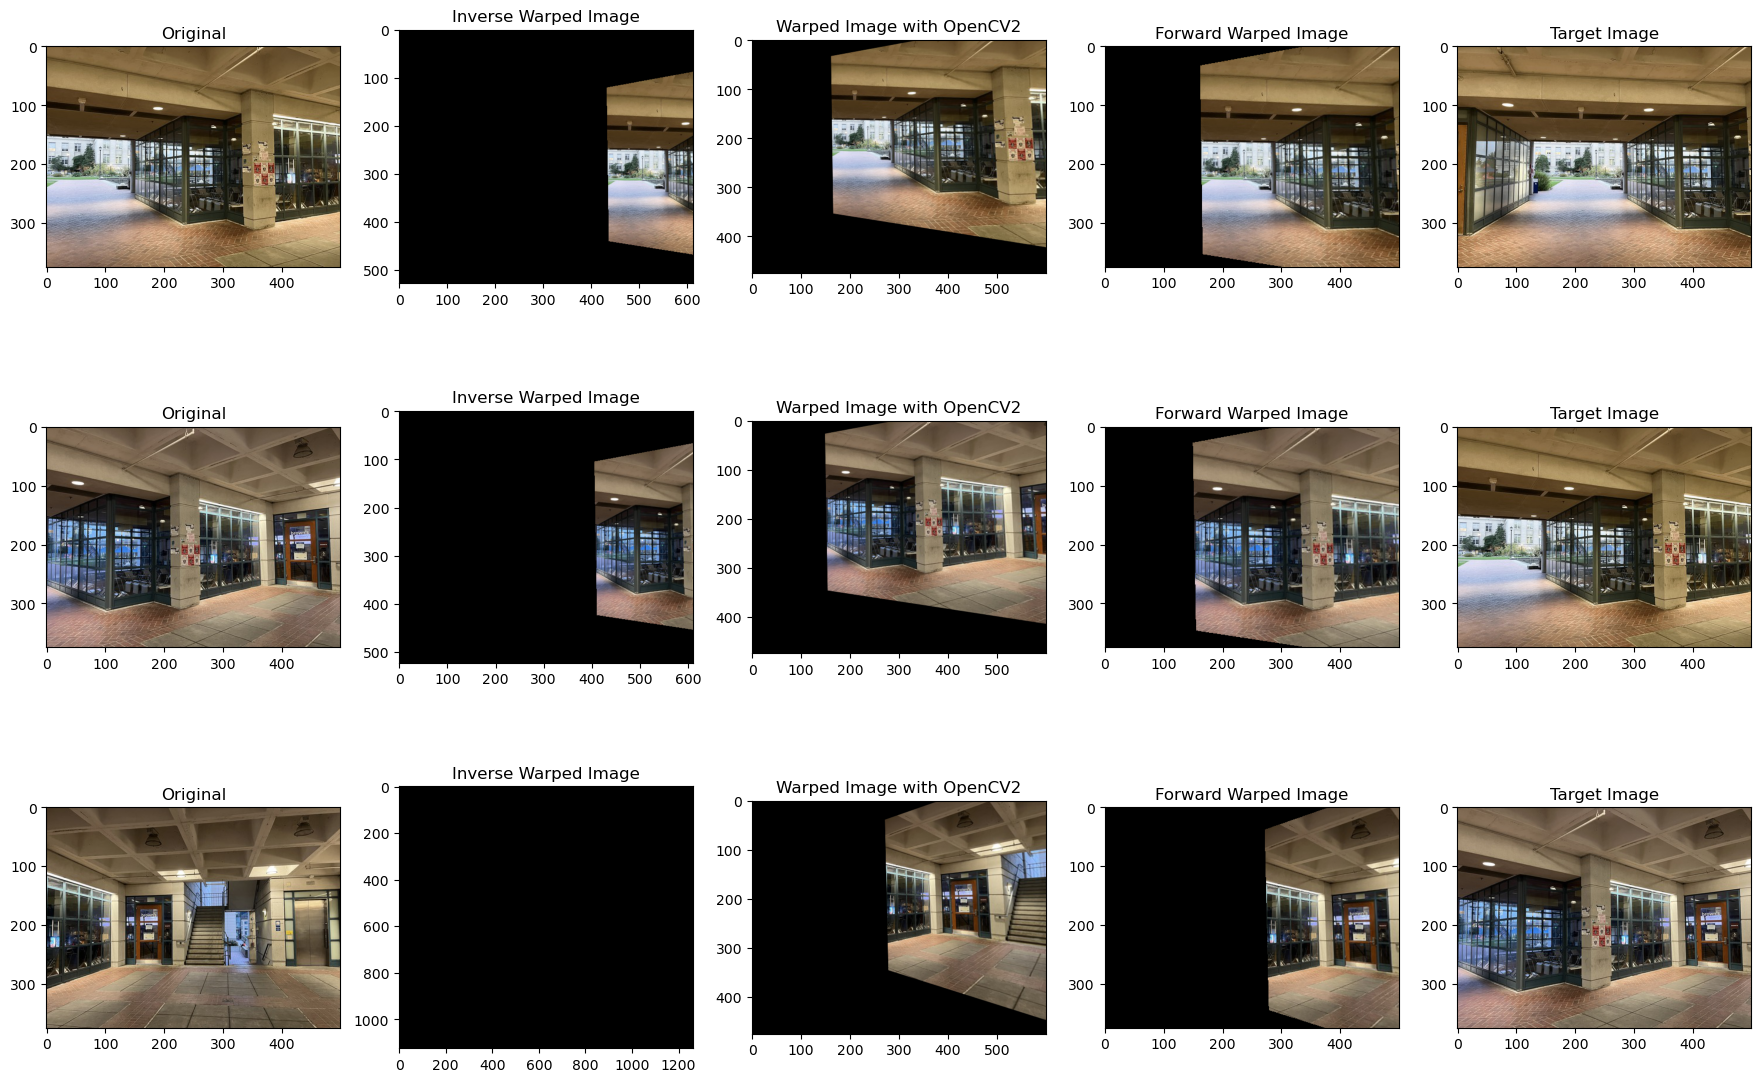

In [4]:
hallway_point_sets = [
    ImagePointSet("hallway/hallway1_hallway2.json"),
    ImagePointSet("hallway/hallway2_hallway3.json"),
    ImagePointSet("hallway/hallway3_hallway4.json")
]
for set in hallway_point_sets:
    set.align_all_points()

mosaic_seq = []
naive_images = []
verify_images = []
for image_point_set in hallway_point_sets:
    homography_matrix = compute_homography_matrix(image_point_set.points[1], image_point_set.points[0])
    mosaic_seq.append((image_point_set.images[1], inverse_warp_image(image_point_set.images[1], homography_matrix), image_point_set.images[0]))
    naive_images.append(forward_warp_image(image_point_set.images[1], homography_matrix))
    verify_images.append(wrap_image_with_cv2(image_point_set.images[1], homography_matrix))

_, axes = plt.subplots(len(mosaic_seq), 5, figsize=(22, 14))
for i in range(len(mosaic_seq)):
    axes[i, 0].imshow(mosaic_seq[i][0])
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(mosaic_seq[i][1])
    axes[i, 1].set_title("Inverse Warped Image")
    axes[i, 2].imshow(verify_images[i])
    axes[i, 2].set_title("Warped Image with OpenCV2")
    axes[i, 3].imshow(naive_images[i])
    axes[i, 3].set_title("Forward Warped Image")
    axes[i, 4].imshow(mosaic_seq[i][2])
    axes[i, 4].set_title("Target Image")

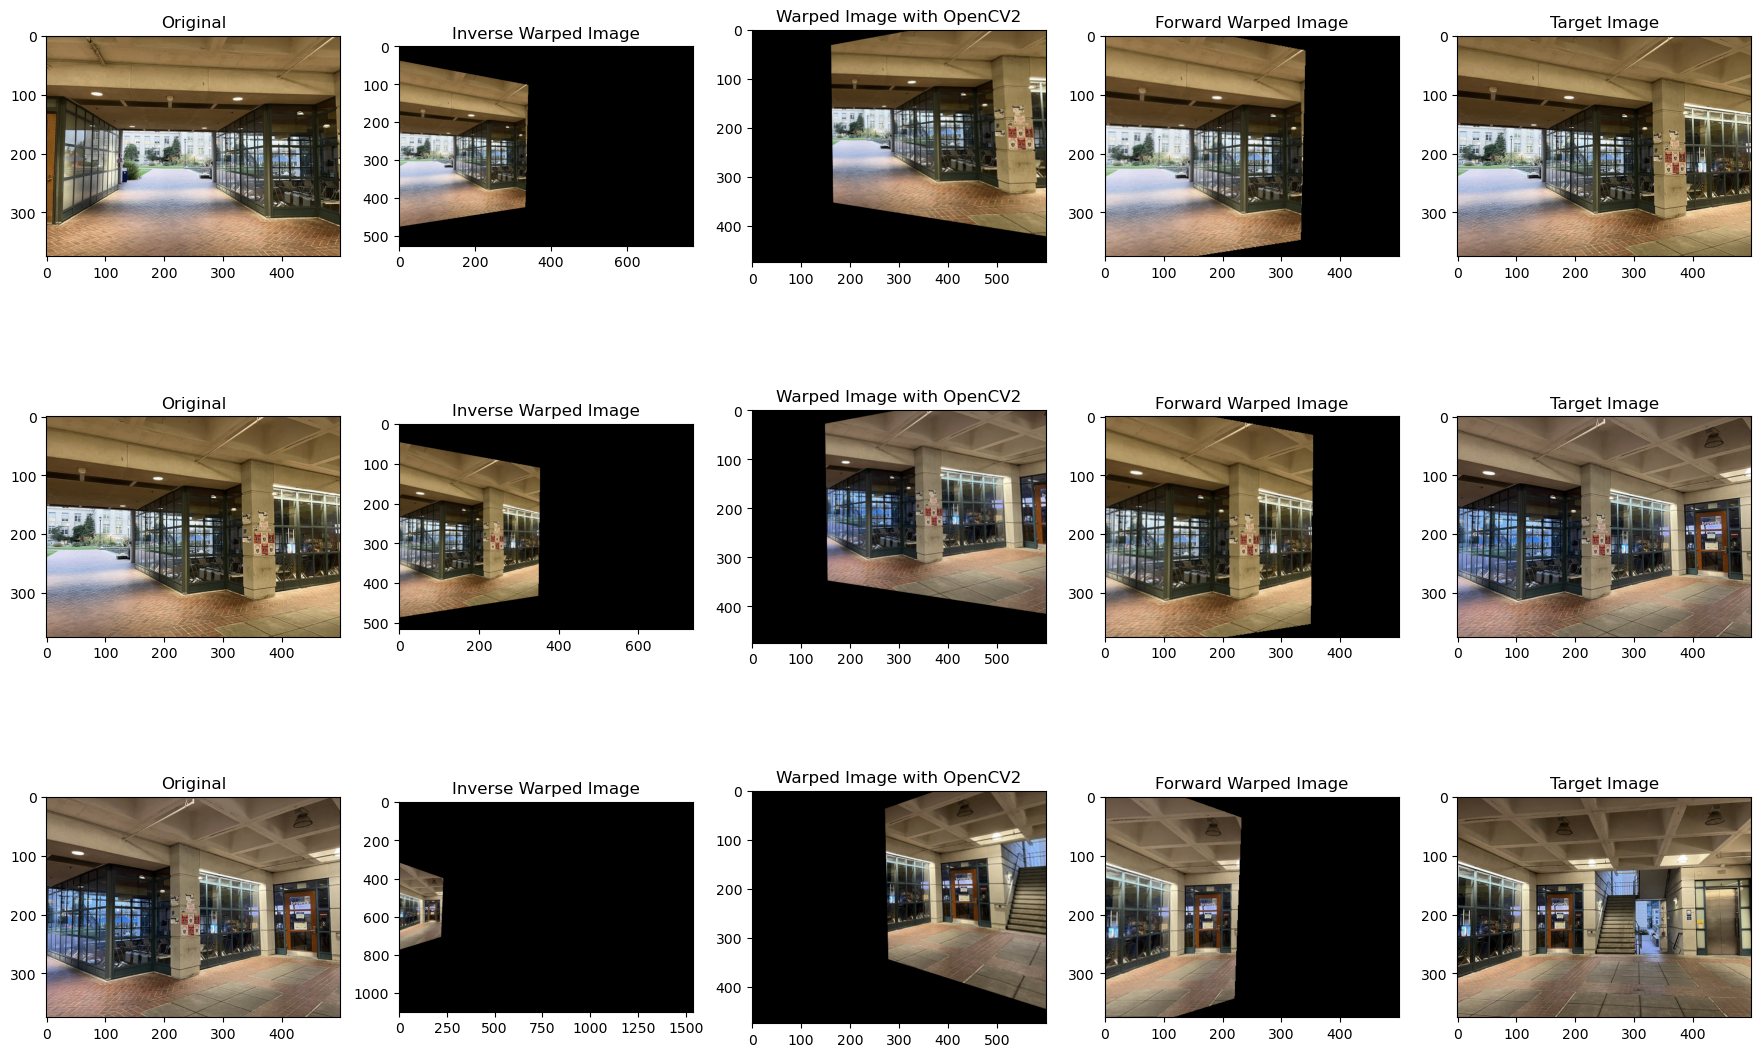

In [5]:
hallway_point_sets = [
    ImagePointSet("hallway/hallway1_hallway2.json"),
    ImagePointSet("hallway/hallway2_hallway3.json"),
    ImagePointSet("hallway/hallway3_hallway4.json")
]
for set in hallway_point_sets:
    set.align_all_points()

mosaic_seq = []
naive_images = []
mosaic_seq = []
for image_point_set in hallway_point_sets:
    homography_matrix = compute_homography_matrix(image_point_set.points[0], image_point_set.points[1])
    mosaic_seq.append((image_point_set.images[0], inverse_warp_image(image_point_set.images[0], homography_matrix), image_point_set.images[1]))
    naive_images.append(forward_warp_image(image_point_set.images[0], homography_matrix))
    verify_images.append(wrap_image_with_cv2(image_point_set.images[0], homography_matrix))

_, axes = plt.subplots(len(mosaic_seq), 5, figsize=(22, 14))
for i in range(len(mosaic_seq)):
    axes[i, 0].imshow(mosaic_seq[i][0])
    axes[i, 0].set_title("Original")
    axes[i, 1].imshow(mosaic_seq[i][1])
    axes[i, 1].set_title("Inverse Warped Image")
    axes[i, 2].imshow(verify_images[i])
    axes[i, 2].set_title("Warped Image with OpenCV2")
    axes[i, 3].imshow(naive_images[i])
    axes[i, 3].set_title("Forward Warped Image")
    axes[i, 4].imshow(mosaic_seq[i][2])
    axes[i, 4].set_title("Target Image")

In [6]:
def combine(left_image, right_image):
    left_mask = np.where(left_image != 0, 1., 0.)
    right_mask = np.where(right_image != 0, 1., 0.)
    combined_mask = left_mask + right_mask
    overlap_mask = np.where(combined_mask != 2, 0., 1.)
    
    non_zero_mask = np.nonzero(overlap_mask)[1]
    
    non_zero_mask_min, non_zero_mask_max = np.min(non_zero_mask), np.max(non_zero_mask)
    gradient_values = np.linspace(0, 1, non_zero_mask_max - non_zero_mask_min)
    grad_format = np.transpose(np.vstack((gradient_values, gradient_values, gradient_values)))
    grad = np.ones_like(overlap_mask)
    grad[:, non_zero_mask_min:non_zero_mask_max, :] = grad_format

    left_grad = (1 - grad) * overlap_mask
    right_grad = (grad) * overlap_mask

    return left_image * ((1 - overlap_mask) + left_grad) + right_image * ((1 - overlap_mask) + right_grad)

325 89 -236
208 116 -92


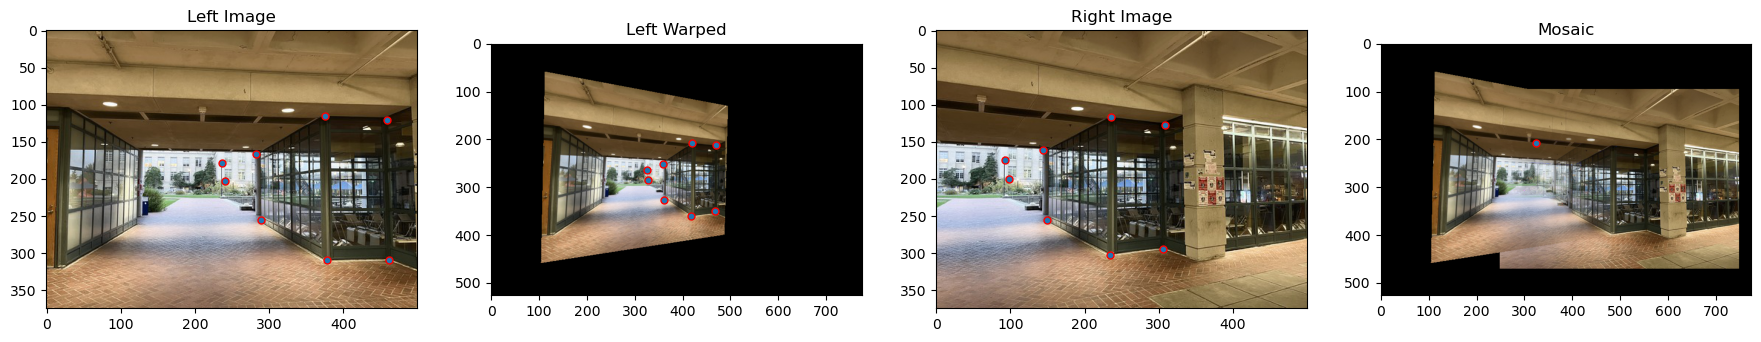

In [8]:
# Create simple mosaic
simple_image_point_set = ImagePointSet("hallway/hallway1_hallway2.json")
simple_image_point_set.align_all_points()

left_image, right_image = simple_image_point_set.images[0], simple_image_point_set.images[1]
left_points, right_points = simple_image_point_set.points[0], simple_image_point_set.points[1]
homography_matrix = compute_homography_matrix(left_points, right_points)
left_warped = inverse_warp_image(left_image, homography_matrix, shift_x=-250)

warped_points_x, warped_points_y = apply_homography(left_points[:, 0] + 250, left_points[:, 1] + 98, homography_matrix)
warped_points_x, warped_points_y = warped_points_x.astype(int), warped_points_y.astype(int)
warped_points = np.vstack([warped_points_x, warped_points_y]).T

simple_image_point_set.change_image(left_warped, 0)
simple_image_point_set.change_points(warped_points, 0)
simple_image_point_set.align_all_points()
# simple_image_point_set.display(True)

min_warped_x, min_right_x = np.min(warped_points_x), np.min(simple_image_point_set.points[1][:, 0])
min_warped_y, min_right_y = np.min(warped_points_y), np.min(simple_image_point_set.points[1][:, 1])

dx = min_right_x - min_warped_x
dy = min_right_y - min_warped_y
size_dx = left_warped.shape[1] - right_image.shape[1]
size_dy = left_warped.shape[0] - right_image.shape[0]

print(min_warped_x, min_right_x, dx)
print(min_warped_y, min_right_y, dy)

padding = (((size_dy // 2) + size_dy % 2, size_dy // 2), ((size_dx // 2) + size_dx % 2, size_dx // 2), (0, 0))
combined_images = np.pad(right_image, padding, mode='constant', constant_values=0)
combined_images = np.roll(combined_images, 20, axis=0)
combined_images = np.roll(combined_images, 110, axis=1)
combined_images = combine(left_warped, combined_images)

_, axes = plt.subplots(1, 4, figsize=(22, 14))
axes[0].imshow(left_image)
axes[0].plot(left_points[:, 0], left_points[:, 1], 'o', markersize=5, markeredgecolor='red')
axes[0].set_title("Left Image")
axes[1].imshow(left_warped)
axes[1].plot(warped_points_x, warped_points_y, 'o', markersize=5, markeredgecolor='red')
axes[1].set_title("Left Warped")
axes[2].imshow(right_image)
axes[2].plot(right_points[:, 0], right_points[:, 1], 'o', markersize=5, markeredgecolor='red')
axes[2].set_title("Right Image")
axes[3].imshow(combined_images)
axes[3].plot(min_warped_x, min_warped_y, 'o', markersize=5, markeredgecolor='red')
axes[3].set_title("Mosaic")

save_image(left_warped, "hallway1_warped")
save_image(combined_images, "hallway1_hallway2_mosaic")